<p style="font-family: Arial; font-size:1.4em;color:gold;"> NOTEBOOK 2 (continuation)</p>

### IMPORT REQUIRED LIBRARIES

In [76]:
import pandas as pd
import gc
import copy
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
import math
from tqdm import tqdm
import numpy as np
from lofo import LOFOImportance, Dataset, plot_importance
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  
import optuna
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import shap

import warnings
warnings.simplefilter('ignore')

In [77]:
X_train_ridge_fillmedian_dropped = pd.read_csv('X_train_ridge_fillmedian_dropped.csv')
X_test_ridge_fillmedian_dropped =pd.read_csv('X_test_ridge_fillmedian_dropped.csv')
y_train_ridge =pd.read_csv('y_train_ridge.csv')
y_test_ridge = pd.read_csv('y_test_ridge.csv')

In [78]:
X_train_lgbm = pd.read_csv('X_train_lgbm.csv')
X_test_lgbm = pd.read_csv('X_test_lgbm.csv')
y_train_lgbm = pd.read_csv('y_train_lgbm.csv')
y_test_lgbm = pd.read_csv('y_test_lgbm.csv')

df_holdout = pd.read_csv('df_holdout.csv')

In [79]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [80]:
clf_ridge = RidgeClassifier()

cross_val_score(clf_ridge, X_train_ridge_fillmedian_dropped, y_train_ridge, cv=folds, scoring='roc_auc')

array([0.74333616, 0.7348053 , 0.74312835, 0.74535668, 0.73435099])

In [81]:
clf_lgbm = lgb.LGBMClassifier()

base_lgbm_score = cross_val_score(clf_lgbm, X_train_lgbm, y_train_lgbm, cv=folds, scoring='roc_auc')
print(base_lgbm_score)

[0.75455274 0.74432699 0.75299693 0.75343694 0.74454875]


-> roc_auc_score is better than accuracy for imbalanced task

# DEALING WITH IMBALANCED DATA

In [82]:
rus = RandomUnderSampler(random_state=42)

In [83]:
sm = SMOTE(sampling_strategy = 'minority',k_neighbors = 5, n_jobs=-1, random_state=42)

#### LightGBM Classifier with RandomUnderSampling

In [84]:
temp_train_lgbm_und = pd.concat([X_train_lgbm.reset_index(drop=True),y_train_lgbm.reset_index(drop=True)],axis=1)

In [85]:
temp_val_lgbm_und = temp_train_lgbm_und.sample(frac=0.15)
temp_train_lgbm_und = temp_train_lgbm_und.drop(temp_val_lgbm_und.index, axis=0) 

y_val_lgbm_frac = temp_val_lgbm_und['TARGET']
X_val_lgbm_frac = temp_val_lgbm_und.drop('TARGET', axis=1)

y_train_lgbm_frac = temp_train_lgbm_und['TARGET']
X_train_lgbm_frac = temp_train_lgbm_und.drop('TARGET', axis=1)

In [86]:
X_train_lgbm_frac_und, y_train_lgbm_frac_und = rus.fit_resample(X_train_lgbm_frac, y_train_lgbm_frac)

In [87]:
clf_lgbm_und = lgb.LGBMClassifier()
clf_lgbm_und.fit(X_train_lgbm_frac_und, y_train_lgbm_frac_und)

LGBMClassifier()

In [88]:
roc_auc_score(y_val_lgbm_frac, clf_lgbm_und.predict_proba(X_val_lgbm_frac)[:, 1])

0.7445885638424077

#### LightGBM Classifier without RandomUnderSampling

In [89]:
clf_lgbm_not_und = lgb.LGBMClassifier()
clf_lgbm_not_und.fit(X_train_lgbm_frac, y_train_lgbm_frac)

LGBMClassifier()

In [90]:
roc_auc_score(y_val_lgbm_frac, clf_lgbm_not_und.predict_proba(X_val_lgbm_frac)[:, 1])

0.7482013212234119

#### LightGBM Classifier with SMOTE Oversampling

-> No matter how much I changed the k_neighbors parameter of SMOTE, it didn't affect the score positively

In [91]:
X_train_lgbm_fillmedian = X_train_lgbm.fillna(X_train_lgbm.median(), inplace=False)
X_test_lgbm_fillmedian = X_test_lgbm.fillna(X_train_lgbm.median(), inplace=False)

-> SMOTE does not work with missing data.

In [92]:
temp_train_lgbm_sm = pd.concat([X_train_lgbm_fillmedian.reset_index(drop=True),y_train_lgbm.reset_index(drop=True)],axis=1)

In [93]:
temp_val_lgbm_sm = temp_train_lgbm_sm.sample(frac=0.15)
temp_train_lgbm_sm = temp_train_lgbm_sm.drop(temp_val_lgbm_sm.index, axis=0) 

y_val_lgbm_frac = temp_val_lgbm_sm['TARGET']
X_val_lgbm_fillmedian_dropped_frac = temp_val_lgbm_sm.drop('TARGET', axis=1)

y_train_lgbm_frac = temp_train_lgbm_sm['TARGET']
X_train_lgbm_fillmedian_dropped_frac = temp_train_lgbm_sm.drop('TARGET', axis=1)

In [94]:
X_train_lgbm_fillmedian_dropped_frac_sm, y_train_lgbm_frac_sm = sm.fit_resample(X_train_lgbm_fillmedian_dropped_frac, y_train_lgbm_frac)

In [95]:
clf_lgbm_sm = lgb.LGBMClassifier()
clf_lgbm_sm.fit(X_train_lgbm_fillmedian_dropped_frac_sm, y_train_lgbm_frac_sm)

LGBMClassifier()

In [96]:
roc_auc_score(y_val_lgbm_frac, clf_lgbm_sm.predict_proba(X_val_lgbm_fillmedian_dropped_frac)[:, 1])

0.7425632065744985

#### LightGBM Classifier without SMOTE Oversampling

In [101]:
clf_lgbm_not_sm = lgb.LGBMClassifier()
clf_lgbm_not_sm.fit(X_train_lgbm_fillmedian_dropped_frac, y_train_lgbm_frac)

LGBMClassifier()

In [102]:
roc_auc_score(y_val_lgbm_frac, clf_lgbm_not_sm.predict_proba(X_val_lgbm_fillmedian_dropped_frac)[:, 1])

0.753407001746286

-> lightgbm also has some parameters to handle the imbalanced data. let's try these too

In [43]:
clf_lgbm_isunb = lgb.LGBMClassifier(is_unbalance=True)
cross_val_score(clf_lgbm_isunb, X_train_lgbm, y_train_lgbm, cv=folds, scoring='roc_auc')

array([0.75450341, 0.74885608, 0.75359801, 0.75478105, 0.7441911 ])

In [44]:
estimate = y_train_lgbm.value_counts()[0] / y_train_lgbm.value_counts()[1]

clf_lgbm_sposw = lgb.LGBMClassifier(scale_pos_weight=estimate)
cross_val_score(clf_lgbm_sposw, X_train_lgbm, y_train_lgbm, cv=folds, scoring='roc_auc')

array([0.75450427, 0.74891306, 0.7535978 , 0.75478097, 0.74484025])

In [45]:
sposw = [25,50,99,100,math.sqrt(estimate)] #for sqrt logic, see https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets

for i in tqdm(range(len(sposw))):
    print(cross_val_score(lgb.LGBMClassifier(scale_pos_weight=sposw[i]), X_train_lgbm, y_train_lgbm, cv=folds, scoring='roc_auc').mean())

  0%|          | 0/5 [00:00<?, ?it/s]

0.7497527441336496
0.7447883720797738
0.7392062437749869
0.7394481310133021
0.7520018325990327


-> resampling doesn't help. lightgbm's relevant parameters will be considered. we will continue with the imbalanced data.

In [103]:
X_train_lgbm.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215257 entries, 0 to 215256
Data columns (total 333 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    SK_ID_CURR                                                  int64  
 1    NAME_CONTRACT_TYPE                                          int64  
 2    CODE_GENDER                                                 float64
 3    FLAG_OWN_CAR                                                int64  
 4    FLAG_OWN_REALTY                                             int64  
 5    CNT_CHILDREN                                                int64  
 6    AMT_INCOME_TOTAL                                            float64
 7    AMT_CREDIT                                                  float64
 8    AMT_ANNUITY                                                 float64
 9    AMT_GOODS_PRICE                                             float64


# <span style='color:blue'> FEATURE ENGINEERING </span>

# FEATURE IMPORTANCE & SELECTION

In [104]:
"""
df_lofo = pd.concat([X_train_lgbm.reset_index(drop=True),y_train_lgbm.reset_index(drop=True)],axis=1)  +10 saat gibi
features_lofo = [col for col in df_lofo.columns if col != "TARGET"]

dataset = Dataset(df = df_lofo, target = "TARGET", features = features_lofo)

lofo_imp = LOFOImportance(dataset, cv=folds, scoring="roc_auc")

importance_df = lofo_imp.get_importance()

plot_importance(importance_df, figsize=(12, 20))

selection = importance_df[importance_df["importance_mean"]>0.0]["feature"].tolist()
"""

'\ndf_lofo = pd.concat([X_train_lgbm.reset_index(drop=True),y_train_lgbm.reset_index(drop=True)],axis=1)  +10 saat gibi\nfeatures_lofo = [col for col in df_lofo.columns if col != "TARGET"]\n\ndataset = Dataset(df = df_lofo, target = "TARGET", features = features_lofo)\n\nlofo_imp = LOFOImportance(dataset, cv=folds, scoring="roc_auc")\n\nimportance_df = lofo_imp.get_importance()\n\nplot_importance(importance_df, figsize=(12, 20))\n\nselection = importance_df[importance_df["importance_mean"]>0.0]["feature"].tolist()\n'

-> I wanted to use LOFO because of the request in the mail. LOFO was working but seemed to take +10 hours based on iteration progress. so, I'm choosing another technique

-> If I had used LOFO, I would have dropped features what appeared to be negative with usage of my `selection` variable according to the LOFO

In [105]:
feature_importances = np.zeros(X_train_lgbm.shape[1])

In [106]:
clf_lgbm = lgb.LGBMClassifier()

In [107]:
for i in range(2):
    
    train_features, valid_features, train_y, valid_y = train_test_split(X_train_lgbm, y_train_lgbm, test_size = 0.2, random_state = i)
    
    clf_lgbm.fit(train_features, train_y, early_stopping_rounds=50,eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    feature_importances += clf_lgbm.feature_importances_

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's auc: 0.752958	valid_0's binary_logloss: 0.247055
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's auc: 0.753274	valid_0's binary_logloss: 0.242776


In [108]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X_train_lgbm.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
39,EXT_SOURCE_1,154.0
41,EXT_SOURCE_3,134.0
40,EXT_SOURCE_2,122.0
16,DAYS_BIRTH,93.0
7,AMT_CREDIT,79.5


In [109]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 43 features with 0.0 importance


,feature,importance
229,Prev_NAME_GOODS_CATEGORY_ClothingandAccessories,0.0
228,Prev_NAME_GOODS_CATEGORY_Medicine,0.0
33,REG_REGION_NOT_WORK_REGION,0.0
34,LIVE_REGION_NOT_WORK_REGION,0.0
332,Prev_POS_NAME_CONTRACT_STATUS_Demand,0.0


-> I'm dropping features with 0 importance.

In [110]:
zero_features_filter_ridge = np.intersect1d(zero_features,list(X_train_ridge_fillmedian_dropped.columns.values))

In [111]:
X_train_lgbm = X_train_lgbm.drop(columns = zero_features, axis=1)
X_test_lgbm = X_test_lgbm.drop(columns = zero_features, axis=1)

print('Training shape: ', X_train_lgbm.shape)

Training shape:  (215257, 290)


In [112]:
clf_lgbm = lgb.LGBMClassifier()

featureimportance_drop_lgbm_score = cross_val_score(clf_lgbm, X_train_lgbm, y_train_lgbm, cv=folds, scoring='roc_auc')
print("before drop by feature importances score:",base_lgbm_score.mean())
print("drop by feature importances score:",featureimportance_drop_lgbm_score.mean())

before drop by feature importances score: 0.749972468030433
drop by feature importances score: 0.7500638099360687


# FEATURE EXTRACTION

-> i could only derive 3 properties. my domain knowledge allowed this much. I don't know what many of the columns mean and I couldn't find it by searching

In [113]:
X_train_lgbm['ANNUITY_INCOME_PERC'] = X_train_lgbm['AMT_ANNUITY'] / X_train_lgbm['AMT_INCOME_TOTAL']
X_test_lgbm['ANNUITY_INCOME_PERC'] = X_test_lgbm['AMT_ANNUITY'] / X_test_lgbm['AMT_INCOME_TOTAL']
X_train_ridge_fillmedian_dropped['ANNUITY_INCOME_PERC'] = X_train_ridge_fillmedian_dropped['AMT_ANNUITY'] / X_train_ridge_fillmedian_dropped['AMT_INCOME_TOTAL']
X_test_ridge_fillmedian_dropped['ANNUITY_INCOME_PERC'] = X_test_ridge_fillmedian_dropped['AMT_ANNUITY'] / X_test_ridge_fillmedian_dropped['AMT_INCOME_TOTAL']

X_train_lgbm['PAYMENT_RATE'] = X_train_lgbm['AMT_ANNUITY'] / X_train_lgbm['AMT_CREDIT']
X_test_lgbm['PAYMENT_RATE'] = X_test_lgbm['AMT_ANNUITY'] / X_test_lgbm['AMT_CREDIT']
X_train_ridge_fillmedian_dropped['PAYMENT_RATE'] = X_train_ridge_fillmedian_dropped['AMT_ANNUITY'] / X_train_ridge_fillmedian_dropped['AMT_CREDIT']
X_test_ridge_fillmedian_dropped['PAYMENT_RATE'] = X_test_ridge_fillmedian_dropped['AMT_ANNUITY'] / X_test_ridge_fillmedian_dropped['AMT_CREDIT']

X_train_lgbm['INCOME_CREDIT_PERC'] = X_train_lgbm['AMT_INCOME_TOTAL'] / X_train_lgbm['AMT_CREDIT']
X_test_lgbm['INCOME_CREDIT_PERC'] = X_test_lgbm['AMT_INCOME_TOTAL'] / X_test_lgbm['AMT_CREDIT']
X_train_ridge_fillmedian_dropped['INCOME_CREDIT_PERC'] = X_train_ridge_fillmedian_dropped['AMT_INCOME_TOTAL'] / X_train_ridge_fillmedian_dropped['AMT_CREDIT']
X_test_ridge_fillmedian_dropped['INCOME_CREDIT_PERC'] = X_test_ridge_fillmedian_dropped['AMT_INCOME_TOTAL'] / X_test_ridge_fillmedian_dropped['AMT_CREDIT']

In [114]:
X_train_ridge = X_train_ridge_fillmedian_dropped.drop(columns = zero_features_filter_ridge, axis=1)
X_test_ridge = X_test_ridge_fillmedian_dropped.drop(columns = zero_features_filter_ridge, axis=1)
#due to the naming, I do this here instead of 2 cells up

In [115]:
control = ['ANNUITY_INCOME_PERC','PAYMENT_RATE','INCOME_CREDIT_PERC']

In [116]:
X_train_lgbm[control].describe().T

,count,mean,std,min,25%,50%,75%,max
ANNUITY_INCOME_PERC,215249.0,0.180900,0.094592,0.005444,0.114745,0.162820,0.228872,1.451571
PAYMENT_RATE,215249.0,0.053683,0.022478,0.022073,0.036900,0.050000,0.064055,0.124430
INCOME_CREDIT_PERC,215257.0,0.398812,0.338515,0.020314,0.193577,0.306667,0.495376,13.125000


In [117]:
extract_lgbm_score = cross_val_score(clf_lgbm, X_train_lgbm, y_train_lgbm, cv=folds, scoring='roc_auc')
print(extract_lgbm_score)

[0.76047704 0.75318845 0.76019096 0.76056211 0.75218434]


In [118]:
print("Base LGBM ROC_AUC Score 5 CV (MEAN):", base_lgbm_score.mean())
print("LGBM with 3 extracted features ROC_AUC Score 5 CV (MEAN):", extract_lgbm_score.mean())
print("Gain with 3 extracted new featuers: +",extract_lgbm_score.mean()-base_lgbm_score.mean())

Base LGBM ROC_AUC Score 5 CV (MEAN): 0.749972468030433
LGBM with 3 extracted features ROC_AUC Score 5 CV (MEAN): 0.7573205783563053
Gain with 3 extracted new featuers: + 0.007348110325872237


-> so, let's continue with the new features

In [119]:
tsne_data = pd.concat([X_train_lgbm, y_train_lgbm], axis=1)[['PAYMENT_RATE','EXT_SOURCE_1','EXT_SOURCE_2','TARGET']].dropna().sample(1000)
tsne_data

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_2,TARGET
142101,0.029238,0.902315,0.647872,0
188979,0.044040,0.380786,0.278945,1
14012,0.051176,0.266988,0.222839,0
112844,0.048349,0.512153,0.124944,0
42371,0.071111,0.566067,0.710309,0
...,...,...,...,...
30837,0.033187,0.722693,0.686618,0
116076,0.026380,0.493360,0.758784,0
110864,0.048873,0.801320,0.210174,0
94691,0.029238,0.600500,0.501084,0


In [120]:
lgbm_feature_names = list(X_train_lgbm.columns)
ridge_features_names = list(X_test_lgbm.columns)

X_train_lgbm_copy = copy.deepcopy(X_train_lgbm)
X_test_lgbm_copy = copy.deepcopy(X_test_lgbm)
X_train_ridge_copy = copy.deepcopy(X_train_ridge)
X_test_ridge_copy = copy.deepcopy(X_test_ridge)

In [121]:
sc = MinMaxScaler()

X_train_lgbm = sc.fit_transform(X_train_lgbm)
X_test_lgbm = sc.transform(X_test_lgbm)

X_train_ridge = sc.fit_transform(X_train_ridge)
X_test_ridge = sc.transform(X_test_ridge)

In [122]:
tsne = TSNE(n_components=3, random_state=0)
projections = tsne.fit_transform(tsne_data)

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=tsne_data.TARGET, labels={'color': 'TARGET'}
)
fig.update_traces(marker_size=8)
fig.show()

-> the relationship of the 3 most important features with target

# <span style='color:blue'> HYPERPARAMETER TUNING </span>

-> I used *OPTUNA* for LightGBM and Ridge

In [123]:
def create_model(trial):
    
    num_leaves = trial.suggest_int("num_leaves", 2, 100)
    n_estimators = trial.suggest_int("n_estimators", 50, 5000)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.1, 5) 
    reg_lambda = trial.suggest_uniform('reg_alpha', 0.1, 5) 
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.1, 50)
    is_unbalance = True
    metric = 'auc'
    
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        min_child_weight = trial.suggest_uniform('min_child_weight', 0.1, 50),
        is_unbalance = True,
        metric = 'auc')
        
    return model

def objective(trial):
    model = create_model(trial)
    
    train_features, valid_features, train_y, valid_y = train_test_split(X_train_lgbm, y_train_lgbm, test_size = 0.2, random_state = 42) 
                                                                        
    model.fit(train_features, train_y, eval_set=[(train_features, train_y), (valid_features, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 50)
    y_proba = model.predict_proba(valid_features)[:,1]
    score = roc_auc_score(valid_y, y_proba)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)
params = study.best_params

print(params)

[I 2021-08-11 13:18:37,540] A new study created in memory with name: no-name-eec144bb-5cb8-4bde-9d67-4565cda41478


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.873146	valid_1's auc: 0.756836
Early stopping, best iteration is:
[190]	training's auc: 0.869254	valid_1's auc: 0.757132


[I 2021-08-11 13:19:36,516] Trial 0 finished with value: 0.7571320457879922 and parameters: {'num_leaves': 61, 'n_estimators': 1525, 'learning_rate': 0.04667515215585908, 'max_depth': 18, 'min_child_samples': 491, 'subsample': 0.7132020600931832, 'colsample_bytree': 0.9726256016310383, 'reg_alpha': 0.710247083259814, 'min_child_weight': 45.80340877780714}. Best is trial 0 with value: 0.7571320457879922.


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.843703	valid_1's auc: 0.754288
[400]	training's auc: 0.892272	valid_1's auc: 0.755747
Early stopping, best iteration is:
[430]	training's auc: 0.897807	valid_1's auc: 0.756037


[I 2021-08-11 13:20:24,782] Trial 1 finished with value: 0.7560368958864165 and parameters: {'num_leaves': 57, 'n_estimators': 741, 'learning_rate': 0.044275501929923376, 'max_depth': 14, 'min_child_samples': 533, 'subsample': 0.9457707093518466, 'colsample_bytree': 0.12745836664021842, 'reg_alpha': 4.1027338140629706, 'min_child_weight': 9.358428488139376}. Best is trial 0 with value: 0.7571320457879922.


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.793527	valid_1's auc: 0.75815
Early stopping, best iteration is:
[164]	training's auc: 0.788831	valid_1's auc: 0.758623


[I 2021-08-11 13:20:43,282] Trial 2 finished with value: 0.7586232356065972 and parameters: {'num_leaves': 38, 'n_estimators': 433, 'learning_rate': 0.17744391761306083, 'max_depth': 3, 'min_child_samples': 944, 'subsample': 0.2074383732959293, 'colsample_bytree': 0.40402380298762697, 'reg_alpha': 1.6360658982781642, 'min_child_weight': 34.809707952030855}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	training's auc: 0.801616	valid_1's auc: 0.750561


[I 2021-08-11 13:20:58,309] Trial 3 finished with value: 0.7505606792655891 and parameters: {'num_leaves': 17, 'n_estimators': 2640, 'learning_rate': 0.3349675131910001, 'max_depth': 20, 'min_child_samples': 1170, 'subsample': 0.5196063423491307, 'colsample_bytree': 0.10754179480853474, 'reg_alpha': 0.5154295928895889, 'min_child_weight': 0.25735141585737686}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	training's auc: 0.848189	valid_1's auc: 0.757893


[I 2021-08-11 13:21:23,703] Trial 4 finished with value: 0.7578930374587216 and parameters: {'num_leaves': 72, 'n_estimators': 2214, 'learning_rate': 0.08911999682643894, 'max_depth': 9, 'min_child_samples': 1071, 'subsample': 0.22641224533435086, 'colsample_bytree': 0.5364717111747724, 'reg_alpha': 4.018897232563039, 'min_child_weight': 33.63995392790885}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds


[I 2021-08-11 13:21:42,646] Trial 5 finished with value: 0.7408310111831151 and parameters: {'num_leaves': 59, 'n_estimators': 3547, 'learning_rate': 0.3209340727124756, 'max_depth': 13, 'min_child_samples': 912, 'subsample': 0.8609308789864611, 'colsample_bytree': 0.9809329360308219, 'reg_alpha': 4.780811837011524, 'min_child_weight': 6.732713094790312}. Best is trial 2 with value: 0.7586232356065972.


Early stopping, best iteration is:
[10]	training's auc: 0.78798	valid_1's auc: 0.740831
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	training's auc: 0.85793	valid_1's auc: 0.753338


[I 2021-08-11 13:22:03,668] Trial 6 finished with value: 0.7533375579507511 and parameters: {'num_leaves': 60, 'n_estimators': 1729, 'learning_rate': 0.17305338968401443, 'max_depth': 9, 'min_child_samples': 450, 'subsample': 0.9506006740692419, 'colsample_bytree': 0.27708517773078345, 'reg_alpha': 2.029775176663766, 'min_child_weight': 49.94951089049382}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	training's auc: 0.82664	valid_1's auc: 0.749902


[I 2021-08-11 13:22:21,027] Trial 7 finished with value: 0.7499015469631047 and parameters: {'num_leaves': 87, 'n_estimators': 1457, 'learning_rate': 0.2529616038608437, 'max_depth': 6, 'min_child_samples': 652, 'subsample': 0.5292346726576451, 'colsample_bytree': 0.7315153665860544, 'reg_alpha': 1.0581063961024735, 'min_child_weight': 28.300093847248267}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	training's auc: 0.79015	valid_1's auc: 0.745327


[I 2021-08-11 13:22:33,850] Trial 8 finished with value: 0.7453273038872995 and parameters: {'num_leaves': 24, 'n_estimators': 3574, 'learning_rate': 0.35084234439454987, 'max_depth': 19, 'min_child_samples': 803, 'subsample': 0.7855079046323918, 'colsample_bytree': 0.406216080657245, 'reg_alpha': 2.416565682488253, 'min_child_weight': 17.03387006768921}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's auc: 0.798131	valid_1's auc: 0.737342


[I 2021-08-11 13:22:47,214] Trial 9 finished with value: 0.7373419397576646 and parameters: {'num_leaves': 80, 'n_estimators': 3549, 'learning_rate': 0.3997756005783812, 'max_depth': 6, 'min_child_samples': 135, 'subsample': 0.21345816754128633, 'colsample_bytree': 0.817565319935208, 'reg_alpha': 0.613655317201614, 'min_child_weight': 21.74006572730588}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	training's auc: 0.794309	valid_1's auc: 0.752356


[I 2021-08-11 13:23:04,655] Trial 10 finished with value: 0.7523556218552521 and parameters: {'num_leaves': 37, 'n_estimators': 92, 'learning_rate': 0.4772036818684138, 'max_depth': 3, 'min_child_samples': 979, 'subsample': 0.11703978539491966, 'colsample_bytree': 0.48829611474523693, 'reg_alpha': 1.9018622779424739, 'min_child_weight': 37.49773646325315}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.787348	valid_1's auc: 0.757372
Early stopping, best iteration is:
[217]	training's auc: 0.789252	valid_1's auc: 0.75775


[I 2021-08-11 13:23:27,445] Trial 11 finished with value: 0.7577501152691032 and parameters: {'num_leaves': 37, 'n_estimators': 4783, 'learning_rate': 0.14456493685734575, 'max_depth': 3, 'min_child_samples': 1200, 'subsample': 0.32493972928984943, 'colsample_bytree': 0.6183599815853016, 'reg_alpha': 3.426256995718802, 'min_child_weight': 33.60978317611439}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[52]	training's auc: 0.839351	valid_1's auc: 0.754371


[I 2021-08-11 13:23:40,581] Trial 12 finished with value: 0.754370711184495 and parameters: {'num_leaves': 97, 'n_estimators': 52, 'learning_rate': 0.12449996485852094, 'max_depth': 9, 'min_child_samples': 1003, 'subsample': 0.3548718864839975, 'colsample_bytree': 0.34599239771925416, 'reg_alpha': 3.267071584908682, 'min_child_weight': 39.18278515531775}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	training's auc: 0.846063	valid_1's auc: 0.749355


[I 2021-08-11 13:23:59,191] Trial 13 finished with value: 0.749355168540101 and parameters: {'num_leaves': 75, 'n_estimators': 2330, 'learning_rate': 0.19737938801223495, 'max_depth': 10, 'min_child_samples': 796, 'subsample': 0.36508471102151185, 'colsample_bytree': 0.5771255630902643, 'reg_alpha': 3.302699776815275, 'min_child_weight': 29.18459883027839}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.70551	valid_1's auc: 0.698701
[400]	training's auc: 0.711675	valid_1's auc: 0.705423
[600]	training's auc: 0.714131	valid_1's auc: 0.708129
[800]	training's auc: 0.716334	valid_1's auc: 0.71021
Did not meet early stopping. Best iteration is:
[984]	training's auc: 0.717857	valid_1's auc: 0.711694


[I 2021-08-11 13:24:54,424] Trial 14 finished with value: 0.7116941259612466 and parameters: {'num_leaves': 2, 'n_estimators': 984, 'learning_rate': 0.0016826793438335375, 'max_depth': 6, 'min_child_samples': 1092, 'subsample': 0.10733405410788949, 'colsample_bytree': 0.4753897626016984, 'reg_alpha': 1.368223146563849, 'min_child_weight': 41.97291860782517}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	training's auc: 0.840119	valid_1's auc: 0.747788


[I 2021-08-11 13:25:13,195] Trial 15 finished with value: 0.7477875231113114 and parameters: {'num_leaves': 46, 'n_estimators': 2710, 'learning_rate': 0.2456305401288883, 'max_depth': 16, 'min_child_samples': 811, 'subsample': 0.23265047245399995, 'colsample_bytree': 0.2449459320275701, 'reg_alpha': 4.2527394188918155, 'min_child_weight': 22.200238741291095}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	training's auc: 0.849237	valid_1's auc: 0.755484


[I 2021-08-11 13:25:36,813] Trial 16 finished with value: 0.7554837048007139 and parameters: {'num_leaves': 73, 'n_estimators': 4844, 'learning_rate': 0.10834841755758673, 'max_depth': 11, 'min_child_samples': 1053, 'subsample': 0.44605369994341987, 'colsample_bytree': 0.6575276297972786, 'reg_alpha': 2.755072688461479, 'min_child_weight': 33.14118100350028}. Best is trial 2 with value: 0.7586232356065972.


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.85537	valid_1's auc: 0.758094
Early stopping, best iteration is:
[162]	training's auc: 0.843245	valid_1's auc: 0.75932


[I 2021-08-11 13:26:04,851] Trial 17 finished with value: 0.7593198303675734 and parameters: {'num_leaves': 45, 'n_estimators': 2118, 'learning_rate': 0.07707319187400667, 'max_depth': 7, 'min_child_samples': 667, 'subsample': 0.6326424984087229, 'colsample_bytree': 0.426629125415264, 'reg_alpha': 1.6520936304476672, 'min_child_weight': 16.31990190959427}. Best is trial 17 with value: 0.7593198303675734.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	training's auc: 0.800439	valid_1's auc: 0.751295


[I 2021-08-11 13:26:22,685] Trial 18 finished with value: 0.7512946574351733 and parameters: {'num_leaves': 28, 'n_estimators': 771, 'learning_rate': 0.22455479963917102, 'max_depth': 5, 'min_child_samples': 306, 'subsample': 0.6580411481209009, 'colsample_bytree': 0.38353072744565775, 'reg_alpha': 1.5576680695822858, 'min_child_weight': 16.25939819959245}. Best is trial 17 with value: 0.7593198303675734.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	training's auc: 0.806618	valid_1's auc: 0.752297


[I 2021-08-11 13:26:42,730] Trial 19 finished with value: 0.7522967225055881 and parameters: {'num_leaves': 46, 'n_estimators': 3140, 'learning_rate': 0.28268955765013715, 'max_depth': 4, 'min_child_samples': 722, 'subsample': 0.6262951557073304, 'colsample_bytree': 0.24593453307159696, 'reg_alpha': 2.2685771121066525, 'min_child_weight': 14.137844100337784}. Best is trial 17 with value: 0.7593198303675734.


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.793602	valid_1's auc: 0.75969
Early stopping, best iteration is:
[233]	training's auc: 0.798662	valid_1's auc: 0.760136


[I 2021-08-11 13:27:14,525] Trial 20 finished with value: 0.7601363509883823 and parameters: {'num_leaves': 13, 'n_estimators': 4214, 'learning_rate': 0.07093669124437835, 'max_depth': 7, 'min_child_samples': 612, 'subsample': 0.4360281167807125, 'colsample_bytree': 0.45688954163330037, 'reg_alpha': 0.20433872791070717, 'min_child_weight': 26.449119123354954}. Best is trial 20 with value: 0.7601363509883823.


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.775918	valid_1's auc: 0.75812
[400]	training's auc: 0.793067	valid_1's auc: 0.760871
[600]	training's auc: 0.807328	valid_1's auc: 0.761308
Early stopping, best iteration is:
[583]	training's auc: 0.806237	valid_1's auc: 0.761463


[I 2021-08-11 13:28:03,158] Trial 21 finished with value: 0.761462865526662 and parameters: {'num_leaves': 9, 'n_estimators': 3794, 'learning_rate': 0.05324091273065057, 'max_depth': 8, 'min_child_samples': 557, 'subsample': 0.45150516461761103, 'colsample_bytree': 0.42595846594745923, 'reg_alpha': 0.1950849080042234, 'min_child_weight': 22.98164028225059}. Best is trial 21 with value: 0.761462865526662.


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.755343	valid_1's auc: 0.748135
[400]	training's auc: 0.764142	valid_1's auc: 0.754734
[600]	training's auc: 0.768967	valid_1's auc: 0.756479
[800]	training's auc: 0.773102	valid_1's auc: 0.757307
Early stopping, best iteration is:
[937]	training's auc: 0.775548	valid_1's auc: 0.75768


[I 2021-08-11 13:29:53,722] Trial 22 finished with value: 0.757679926158785 and parameters: {'num_leaves': 3, 'n_estimators': 4164, 'learning_rate': 0.06156510636908902, 'max_depth': 7, 'min_child_samples': 602, 'subsample': 0.4571564674894514, 'colsample_bytree': 0.4882846370119413, 'reg_alpha': 0.11308011852474698, 'min_child_weight': 23.46262142740758}. Best is trial 21 with value: 0.761462865526662.


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.766391	valid_1's auc: 0.752715
[400]	training's auc: 0.778259	valid_1's auc: 0.757654
[600]	training's auc: 0.788027	valid_1's auc: 0.759912
[800]	training's auc: 0.796771	valid_1's auc: 0.760736
[1000]	training's auc: 0.804893	valid_1's auc: 0.76117
Early stopping, best iteration is:
[964]	training's auc: 0.803423	valid_1's auc: 0.761191


[I 2021-08-11 13:31:05,330] Trial 23 finished with value: 0.7611911207721248 and parameters: {'num_leaves': 13, 'n_estimators': 4233, 'learning_rate': 0.019055005062281548, 'max_depth': 8, 'min_child_samples': 365, 'subsample': 0.5905868316670119, 'colsample_bytree': 0.32761426489239576, 'reg_alpha': 0.11438467209744504, 'min_child_weight': 18.545316526584582}. Best is trial 21 with value: 0.761462865526662.


Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.761647	valid_1's auc: 0.751061
[400]	training's auc: 0.769038	valid_1's auc: 0.754929
[600]	training's auc: 0.776198	valid_1's auc: 0.757579
[800]	training's auc: 0.782139	valid_1's auc: 0.759123
[1000]	training's auc: 0.787793	valid_1's auc: 0.760303
[1200]	training's auc: 0.793016	valid_1's auc: 0.761015
[1400]	training's auc: 0.797954	valid_1's auc: 0.761253
Early stopping, best iteration is:
[1455]	training's auc: 0.799272	valid_1's auc: 0.761332


[I 2021-08-11 13:33:47,506] Trial 24 finished with value: 0.7613319158012383 and parameters: {'num_leaves': 12, 'n_estimators': 4235, 'learning_rate': 0.012530811213125551, 'max_depth': 8, 'min_child_samples': 361, 'subsample': 0.44585817347932455, 'colsample_bytree': 0.29431638686375905, 'reg_alpha': 0.11356634847634384, 'min_child_weight': 27.75197858309521}. Best is trial 21 with value: 0.761462865526662.


{'num_leaves': 9, 'n_estimators': 3794, 'learning_rate': 0.05324091273065057, 'max_depth': 8, 'min_child_samples': 557, 'subsample': 0.45150516461761103, 'colsample_bytree': 0.42595846594745923, 'reg_alpha': 0.1950849080042234, 'min_child_weight': 22.98164028225059}


In [124]:
study.best_value

0.761462865526662

In [125]:
study.best_params

{'num_leaves': 9,
 'n_estimators': 3794,
 'learning_rate': 0.05324091273065057,
 'max_depth': 8,
 'min_child_samples': 557,
 'subsample': 0.45150516461761103,
 'colsample_bytree': 0.42595846594745923,
 'reg_alpha': 0.1950849080042234,
 'min_child_weight': 22.98164028225059}

In [126]:
optuna.visualization.plot_param_importances(study)

In [129]:
clf_lgb_final = lgb.LGBMClassifier(**study.best_params)

In [69]:
def create_model(trial):
    
    alpha = trial.suggest_uniform('alpha', 0.0001, 1)
    
    model = RidgeClassifier(alpha=alpha)
        
    return model

def objective(trial):
    model = create_model(trial)
    
    train_features, valid_features, train_y, valid_y = train_test_split(X_train_ridge, y_train_ridge, test_size = 0.2, random_state = 42) 
                                                                        
    model.fit(train_features, train_y)
    y_proba = model.decision_function(valid_features)
    score = roc_auc_score(valid_y, y_proba)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
params = study.best_params

print(params)

[I 2021-08-11 03:41:42,969] A new study created in memory with name: no-name-528bbef4-1824-4116-9bff-6b79f4b24595
[I 2021-08-11 03:41:47,125] Trial 0 finished with value: 0.7395394079479916 and parameters: {'alpha': 0.2554709122299334}. Best is trial 0 with value: 0.7395394079479916.
[I 2021-08-11 03:41:51,249] Trial 1 finished with value: 0.7395394151343445 and parameters: {'alpha': 0.15535537216475814}. Best is trial 1 with value: 0.7395394151343445.
[I 2021-08-11 03:41:55,265] Trial 2 finished with value: 0.7395398894336463 and parameters: {'alpha': 0.3223920787357874}. Best is trial 2 with value: 0.7395398894336463.
[I 2021-08-11 03:41:59,246] Trial 3 finished with value: 0.7395367058792416 and parameters: {'alpha': 0.7025812712848207}. Best is trial 2 with value: 0.7395398894336463.
[I 2021-08-11 03:42:03,277] Trial 4 finished with value: 0.7395339463196673 and parameters: {'alpha': 0.8298147634168743}. Best is trial 2 with value: 0.7395398894336463.
[I 2021-08-11 03:42:07,307] Tr

{'alpha': 0.36217502861127354}


In [70]:
study.best_params

{'alpha': 0.36217502861127354}

In [71]:
study.best_value

0.7395401265832973

-> LightGBM looks better. so I will continue with it.

# LIGHTGBM MODEL EVALUATION

-> since the outputs related to the model come in a long time, tuning+evaluation performance improvement iteration will not be applied. only the first results will be taken. but what needs to be done will be written

In [130]:
clf_lgb_final.fit(X_train_lgbm, y_train_lgbm)
tuned = roc_auc_score(y_test_lgbm, clf_lgb_final.predict_proba(X_test_lgbm)[:, 1])
tuned

0.7589874234125923

In [131]:
clf_lgb_not_tuned = lgb.LGBMClassifier()
clf_lgb_not_tuned.fit(X_train_lgbm, y_train_lgbm)
not_tuned = roc_auc_score(y_test_lgbm, clf_lgb_not_tuned.predict_proba(X_test_lgbm)[:, 1])
not_tuned

0.7622183662009268

In [132]:
print("Tuned model score:", tuned)
print("Not Tuned model score:", not_tuned)

Tuned model score: 0.7589874234125923
Not Tuned model score: 0.7622183662009268


<p style="font-family: Arial; font-size:1.4em;color:green;"> Maildeki 6. Madde için; </p> 

<span style='color:green'> Feature importance, Feature Extraction, Hyperparameter tuning aşamaları için öncesi ve sonrası skor printlerini topluca hatırlatmak istiyorum. Sonuçlar çapraz doğrulanmıştır </span>

<span style='color:green'> Base LGBM ROC_AUC Score: 0.749972468030433
LGBM with 3 extracted features ROC_AUC Score 5:7573205783563053 </span>

<span style='color:green'> before drop by feature importances score: 0.749972468030433
drop by feature importances score: 0.7500638099360687 </span>

<span style='color:green'> Tuned model score: 0.7589874234125923
Not Tuned model score: 0.7622183662009268 </span>

-> we will see other details of model in the comparison of the base model and tuned model by plotting the learning curve output in the model evaluation section.

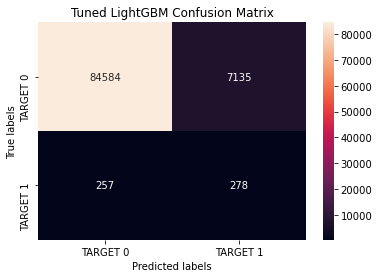

In [133]:
y_pred = clf_lgb_final.predict(X_test_lgbm)
conf_lgbm = confusion_matrix(y_pred,y_test_lgbm)

ax= plt.subplot()
sns.heatmap(conf_lgbm, fmt='d', annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Tuned LightGBM Confusion Matrix'); 
ax.xaxis.set_ticklabels(['TARGET 0', 'TARGET 1']); ax.yaxis.set_ticklabels(['TARGET 0', 'TARGET 1']);

-> The estimates for the rare TARGET 1 class look pretty bad. because of imbalanced. but oversampling and undersampling didn't work either. precision and recall values will also be pretty bad.

In [134]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

Tuned LightGBM Classification Report


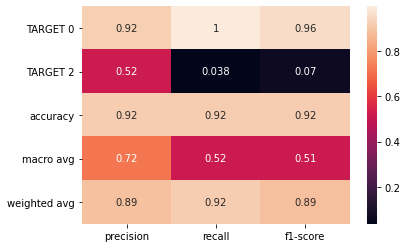

In [135]:
print('Tuned LightGBM Classification Report')
target_names=['TARGET 0','TARGET 2']
classificationReport = classification_report(y_test_lgbm, y_pred, target_names=target_names,output_dict=True)
sns.heatmap(pd.DataFrame(classificationReport).iloc[:-1, :].T, annot=True);

In [136]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("roc_auc Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Wall time: 1h 5min 23s


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

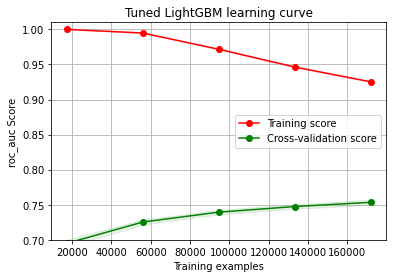

In [137]:
%%time
plot_learning_curve(clf_lgb_final, "Tuned LightGBM learning curve", X_train_lgbm, y_train_lgbm, ylim=(0.70, 1.01), cv=folds, n_jobs=1)

-> I think that's the overfitting, high variance is seen. the train and validation distributions may be different, but I used cross validation for this. maybe a bigger train set would have been preferred. as training examples increase, overfitting downs. but since our data is limited to this sample, it would be better to start without overfitting. the model should be less complex

-> gap seems to be too big

-> how to deal with it ? We can collect more data if we can. we can do a stronger cross validation. we may drop some features. a better value can be chosen for an early stop. resolving data quality issues and removing outliers

-> The first thing I would do to fix this problem would be to reduce the number of estimators.

-> how can we use hyperparameters of lightgbm to avoid overfitting?
Try smaller estimator number
Use small max_bin,
Use small num_leaves,
Use min_data_in_leaf and min_sum_hessian_in_leaf,
Use bagging by set bagging_fraction and bagging_freq,
Use feature sub-sampling by set feature_fraction,
Use bigger training data,
Try lambda_l1, lambda_l2 and min_gain_to_split for regularization,
Try max_depth to avoid growing deep tree,
Try extra_trees,
Try increasing path_smooth

-> I have to give the current hyperparameter range according to these suggestions and then re-tune.

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

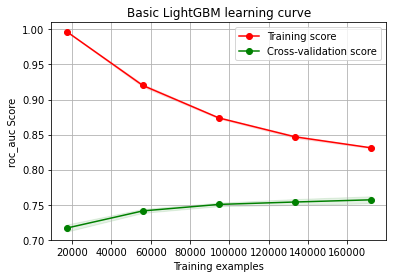

In [142]:
plot_learning_curve(clf_lgb_not_tuned, "Basic LightGBM learning curve", X_train_lgbm, y_train_lgbm, ylim=(0.70, 1.01), cv=folds, n_jobs=1)

-> however, within the scope of this task, I will not continue the model improvement part with evualution iterations. 

-> I don't think I have a very long time to assign this notebook, so I won't continue to re-tuning, improve on this part. but I have stated what needs to be done.

# <span style='color:blue'> MODEL EXPLAINABILITY </span>

In [80]:
clf_for_shap = lgb.LGBMClassifier()
clf_for_shap.fit(X_train_lgbm, y_train_lgbm)

In [81]:
#explainer_shap = shap.TreeExplainer(clf_lgb_final)      I THINK THAT'S MAYBE THE CORRECT ONE. BUT TAKING TOO LONG TIME
explainer_shap = shap.TreeExplainer(clf_for_shap)

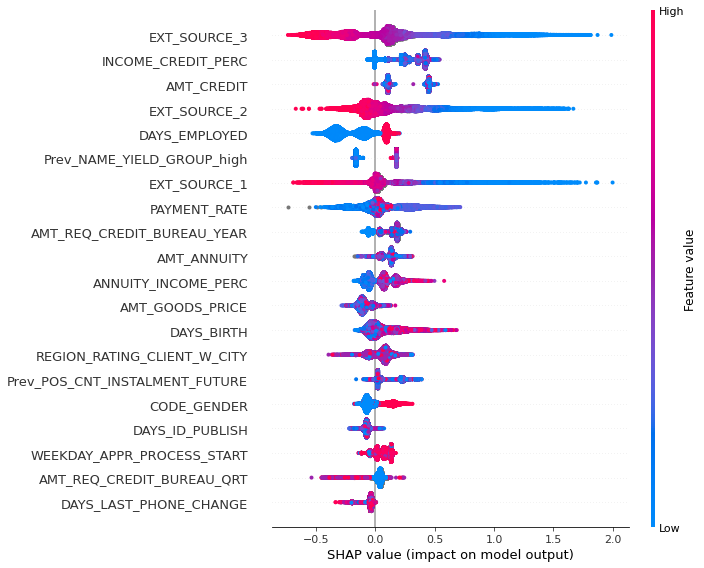

In [82]:
shap_values = explainer_shap.shap_values(X_test_lgbm_copy)
shap.summary_plot(shap_values[1],X_test_lgbm_copy)

-> the summary plot combines feature importance with feature effects. EXT_SOURCE_3,2,1 are correlated each other. importances are ranked in descending order. all dots are from the train data. the horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

-> let's pick a feature and comment it out! Let's remember that CODE GENDER 0: Female and CODE GENDER 1: Male. we see that high feature value, that is, being a man (red ones), makes high the model output, that is, it offers a tendency not to repay the debt.

-> effects are over test observation. as will be below.

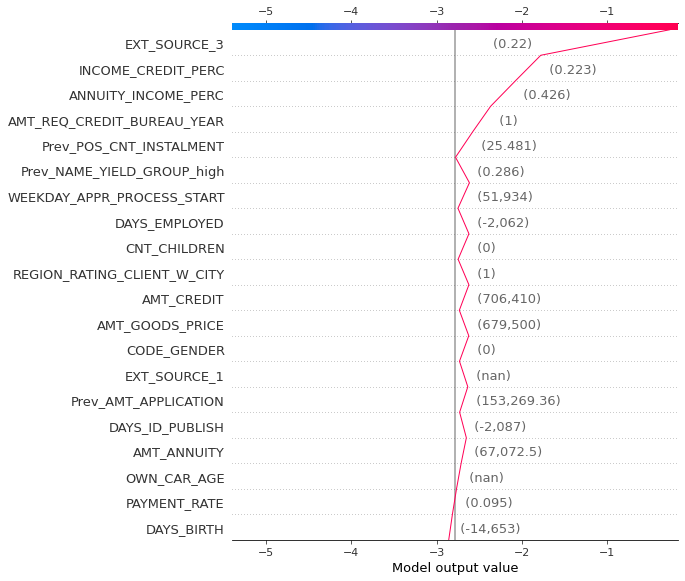

In [86]:
shap.decision_plot(explainer_shap.expected_value[1], shap_values[1][0,:], X_train_lgbm_copy.iloc[0,:])

-> it shows with what effects the features take us from the baseline value (expected model output over the background dataset) to the current model output. if we look at the horizontal intervals, they are ordered by importance.

-> the units are log odds.

In [87]:
shap.initjs()
shap_values = explainer_shap.shap_values(X_train_lgbm_copy)
shap.force_plot(explainer_shap.expected_value[1], shap_values[1][0,:], X_train_lgbm_copy.iloc[0,:])

-> the above plot shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. features pushing the prediction higher are shown in red and those pushing the prediction lower are in blue

-> for example, the value -2.062 of DAYS_EMPLOYED pushed the model output down. the 0.02201 value of EXT_SOURCE_3 pushed the model output up.

-> as you can see, the decision plot can be useful for outlier detection

-> the bigger the arrow, the bigger the impact and they are in order.

-> There are also dependency plots in SHAP

In [ ]:
"""
clf_lgb_final.predict(df_holdout)"""

-> symbolic prediction

<p style="font-family: Arial; font-size:1.4em;color:RED;"> YORUMLAR </p> 

- Resamplingli - resamplingsiz, droplu - dropsuz, basic model - tuned model gibi kıyaslamalar tüm aşamalarda notebook üzerinde görülmektedir. 

- İlk baştaki 10 csv'yi tek dataset haline getirirken, `reduce_mem()`  fonksiyonu uygulamama ve del,garbage collector kullanmama ragmen bellek doldu. Dolayısıyla önişleme aşaması sonucu elde ettiğim datasetleri kaydedip başka bir notebookta oradan devam etmek zorunda kaldım 

- Bu asessment kapsamında; süre kazanmak için tabloların birleştirildiği hazır bir kod kullandım, outlier analizi kısmına girmek istemedim, EDA kısmını çok kısa tuttum, genel olarak model öncesi aşamalar için oldukça hızlı geçilmiştir, Tuning ve değerlendirme arasında git geller ile iterasyonlarla modeli iyileştirmem gereken kısımda sadece ilk çıktıları verip ne yapılması gerektiğini belirttim(uzun sürecekti). Sonuç elde edebileceğim en iyi sonuç değildir. Harcadığım süre kapsamında elde edebildiğim sonuçtur. 

- En büyük sorunu missing valule'ların doldurulmasında yaşadım. Python bu konuda R'dan daha zayıf. R'daki MICE imputing'i Python'da IterativeImputer ile yapabiliyoruz fakat hem bunun için hem de model bazlı imputingler için out of memory hatası aldım. Dolayısıyla mean ve median ile doldurma gibi basit yöntemleri seçmem gerekti fakat missing value yüzdeleri oldukça yüksekti. Çok geçerli bir uygulama olmasa da bunu yaparak devam etmiş oldum. 

- Diğer büyük bir sorun dengesiz veriseti yapısından kaynaklıydı. Oversampling de undersampling de iyi sonuçlar vermedi dolayısıyla imbalanced yapı ile devam etmem gerekti. LightGBM'in bu konuda destek olabilecek parametrelerinin de bir katkısı olmadı. Dolayısıyla recall-f1-precision gibi metriklerde iyi sonuç almak çok zorlaştı. Fakat görüyorum ki kaggle yarışmasındaki 1. yarışmacının auc puanı 0.8 seviyesinde ve benim auc puanımın 0.76 olduğunu düşünürsek bu soruna insanların da açık ara etkili bir çözüm getiremediğini görüyorum. 

- Özellik çıkarma konusunda domain bilgimin zayıflığı sebebiyle sadece 3 özellik ekleyebildim. fakat başarı oranı konusunda bunun oldukça önemli olduğunu düşünüyorum. vaktim olsa ilk yapacağım şey değişkenleri araştırıp anlayıp yeni özellikler türetmek olurdu. 

- LOFO Importance kullanmam istenmişti. Uygulayacak kodu yazdım, çalışıyordu da fakat iterasyon ilerlemesine bakarsam çok uzun sürecek gibiydi. Dolayısıyla yoruma aldım. Tamamlanmış olsa, yorum içinde `selection` değişkeni ile selection yapmış olacaktım.

- Hyperparameter tuning için OPTUNA'nın hız ve başarı anlamında optimal bir şekilde çalıştığını düşünüyorum. Overfitting'ten kaçınmak için yapılması gerekenleri yazdım. Bu öneriler ile tekrar tune ederek ve tekrar learning curve görerek iterasyonlarla bu sorunun üstesinden gelinebilirdi fakat alacağı süre bakımından bu yolu seçmedim. İlk sonuçları ile bıraktım.